# Transforming RNAseq data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

### Basic Checks and QC

In [2]:
transcript_df = pd.read_csv("./data/pigs_rna_seq.csv", index_col=0)
display(transcript_df.head())
transcript_transposed_df = transcript_df.transpose()
print(f"There are {transcript_transposed_df.isna().sum().sum()} missing/NaN values")
display(transcript_transposed_df.head())

,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
gene,,,,,,,,,,,,
ENSSSCG00000000002,219,354,308,416,308,444,673,588,354,547,747,545
ENSSSCG00000000003,2602,2393,2450,683,2864,1775,1367,985,2456,1913,1610,620
ENSSSCG00000000005,162,130,153,261,226,218,277,170,195,201,271,184
ENSSSCG00000000006,1275,966,1547,1004,1424,1097,868,914,1312,1153,1271,619
ENSSSCG00000000007,263,291,348,360,282,343,550,468,372,451,530,439


There are 0 missing/NaN values


gene,ENSSSCG00000000002,ENSSSCG00000000003,ENSSSCG00000000005,ENSSSCG00000000006,ENSSSCG00000000007,ENSSSCG00000000010,ENSSSCG00000000014,ENSSSCG00000000018,ENSSSCG00000000019,ENSSSCG00000000020,...,ENSSSCG00000063546,ENSSSCG00000063547,ENSSSCG00000063548,ENSSSCG00000063549,ENSSSCG00000063550,ENSSSCG00000063551,ENSSSCG00000063552,ENSSSCG00000063553,ENSSSCG00000063554,ENSSSCG00000063555
PIG1,219,2602,162,1275,263,5656,1072,2780,3031,7,...,3,0,3,0,0,7,0,1351,7,1
PIG2,354,2393,130,966,291,5959,865,3025,3601,16,...,25,0,0,0,0,7,0,1056,1,1
PIG3,308,2450,153,1547,348,8491,1718,3014,4252,3,...,19,0,2,0,0,17,0,1128,6,0
PIG4,416,683,261,1004,360,34450,829,6027,3459,33,...,14,0,0,0,0,16,0,400,0,0
PIG5,308,2864,226,1424,282,8959,1462,3682,4571,16,...,14,0,0,0,0,9,0,1444,7,0


In [3]:
# Load metadata
metadata_df = pd.read_csv("./data/metadata.csv")

# Check column names and first few rows
print("Metadata columns:", metadata_df.columns)
display(metadata_df.head())

# Standardizing sample names (assuming 'Pig' column stores sample identifiers)
metadata_df.rename(columns={'Pig ': 'Pig'}, inplace=True)  # Fix any trailing spaces
metadata_df['Pig'] = metadata_df['Pig'].astype(str)  # Convert to string for comparison

# Standardize sample names in transcript data (e.g., PIG1, PIG2, ...)
metadata_df['Pig'] = metadata_df['Pig'].apply(lambda x: f'PIG{x}')

# Check if all RNA-seq sample columns exist in metadata
rna_seq_samples = set(transcript_transposed_df.index)
metadata_samples = set(metadata_df['Pig'])

missing_in_metadata = rna_seq_samples - metadata_samples
missing_in_rna_seq = metadata_samples - rna_seq_samples

print("Samples in RNA-seq but missing in metadata:", missing_in_metadata)
print("Samples in metadata but missing in RNA-seq:", missing_in_rna_seq)

Metadata columns: Index(['Pig ', 'Treatment', 'Day Euthanized', 'Max Fecal Score'], dtype='object')


,Pig,Treatment,Day Euthanized,Max Fecal Score
0,1,Sham,21,0
1,2,Sham,21,0
2,3,Sham,21,0
3,4,Sham,21,0
4,5,Bhyo,21,2


Samples in RNA-seq but missing in metadata: set()
Samples in metadata but missing in RNA-seq: set()


In [4]:
#Threshold Settings
LOW_EXPRESSION_THRESHOLD = 10 #This is the standard minimum expression value for the gene to be retained
VARIANCE_THRESHOLD = 0.25 #This is the standard minimum amount of variance for the gene to be retained

### Remove Low expression genes

In [5]:
# Filter out lowly expressed genes
filtered_transcript_df = transcript_df.loc[transcript_df.sum(axis=1) >= LOW_EXPRESSION_THRESHOLD]
print(f"Number of genes before filtering: {transcript_df.shape[0]}")
print(f"Number of genes after filtering: {filtered_transcript_df.shape[0]}")

#save_intermediate_file
filtered_transcript_df.to_csv("./data/outputs/rnaseq/filtered_transcript_df.csv",index=True)

Number of genes before filtering: 35670
Number of genes after filtering: 23910


### Log Transform
Use the natural log to reduce the effect of large outliers.

In [8]:
#Natural log transform
pseudo_count = 1 #To avoid 0s
ln_transcript_df = filtered_transcript_df.apply(lambda x: np.log(x + pseudo_count))
ln_transcript_df.to_csv("./data/outputs/rnaseq/ln_transcript_rnaseq.csv")
ln_transcript_df.describe()

,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
count,23910.000000,23910.000000,23910.000000,23910.000000,23910.000000,23910.000000,23910.000000,23910.000000,23910.000000,23910.000000,23910.000000,23910.000000
mean,5.009683,4.806879,5.123280,4.900548,4.912850,4.980029,4.856819,4.989234,4.682233,4.854276,5.090023,4.935152
std,2.516373,2.657716,2.624175,2.768839,2.747098,2.796876,2.995247,2.689754,2.852131,2.892687,2.881086,2.691191
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.995732,2.564949,2.995732,2.564949,2.564949,2.564949,2.197225,2.772589,2.197225,2.302585,2.639057,2.639057
50%,5.446737,5.241747,5.560682,5.393628,5.407172,5.451038,5.361292,5.411646,5.093750,5.257495,5.579730,5.370638
75%,7.035269,6.998510,7.250458,7.202475,7.204893,7.321023,7.419231,7.221105,7.098995,7.314386,7.508787,7.170888
max,13.299518,13.284916,13.512135,13.935119,13.701840,13.620404,14.268608,13.535940,13.842056,13.784417,14.253356,13.336653


### Select the top 1000 variable genes

In [10]:
# Compute variance across all samples
gene_variances = ln_transcript_df.var(axis=1)

# Select top 1000 most variable genes
top_variable_genes = gene_variances.nlargest(1000).index

# Subset the data
high_variance_ln_df = ln_transcript_df.loc[top_variable_genes]

# Save the filtered dataset
high_variance_ln_df.to_csv("./data/outputs/rnaseq/high_variance_ln_transcript.csv", index=True)

# Display summary
print(f"Original genes: {ln_transcript_df.shape[0]}")
print(f"Genes after high-variance filtering: {high_variance_ln_df.shape[0]}")

high_variance_ln_df.describe()

Original genes: 23910
Genes after high-variance filtering: 1000


,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.224872,2.888060,3.200714,2.848439,3.022379,3.039083,2.716604,3.045602,2.338649,2.550272,2.954776,2.987886
std,2.048849,2.144288,2.189454,2.419976,2.262531,2.326296,2.582982,2.136088,2.272836,2.313695,2.259765,2.122207
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.079442,1.386294,1.791759,0.693147,1.609438,1.386294,0.000000,1.609438,0.000000,0.693147,1.386294,1.609438
50%,3.135494,2.639057,2.995732,2.639057,2.708050,2.772589,2.302585,2.802901,1.945910,2.197225,2.708050,2.833213
75%,4.143135,3.828641,4.114939,4.237704,4.043051,4.248495,4.234107,4.234107,3.644080,3.916974,4.174387,4.043051
max,11.756428,10.702975,11.203516,11.051461,11.212941,12.152023,12.860986,12.524923,12.475676,12.266664,12.735500,12.508493


## Heatmap and Hierarchical clustering

In [12]:
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

In [42]:
# Load high-variance log-transformed data
high_variance_ln_df = pd.read_csv("./data/outputs/rnaseq/high_variance_ln_transcript.csv", index_col=0)

# Load metadata to identify control (Sham) samples
metadata_df = pd.read_csv("./data/metadata.csv")
metadata_df.rename(columns={'Pig ': 'Pig'}, inplace=True)  # Fix spaces if needed
metadata_df['Pig'] = metadata_df['Pig'].astype(str)
metadata_df['Pig'] = metadata_df['Pig'].apply(lambda x: f'PIG{x}')  # Match RNA-seq names
# Identify control (Sham) sample columns
sham_samples = metadata_df[metadata_df['Treatment'] == "Sham"]['Pig'].tolist()

# Compute mean & std of control (Sham) samples per gene
sham_mean = high_variance_ln_df[sham_samples].mean(axis=1)
sham_std = high_variance_ln_df[sham_samples].std(axis=1)

# Avoid division by zero by replacing 0 std with a small value (e.g., 1e-6)
sham_std_safe = sham_std.replace(0, 1e-6)

# Compute Z-scores safely (expression relative to Sham)
z_score_df = (high_variance_ln_df - sham_mean.values.reshape(-1, 1)) / sham_std_safe.values.reshape(-1, 1)
z_score_df = z_score_df.fillna(0)  # Fill NaN values with 0

# Perform hierarchical clustering on genes (rows)
row_linkage = sch.linkage(dist.pdist(z_score_df, metric="euclidean"), method="ward")
row_dendro = sch.dendrogram(row_linkage, no_plot=True)
row_order = row_dendro['leaves']

# Perform hierarchical clustering on samples (columns)
col_linkage = sch.linkage(dist.pdist(z_score_df.T, metric="euclidean"), method="ward")
col_dendro = sch.dendrogram(col_linkage, no_plot=True)
col_order = col_dendro['leaves']
display(z_score_df.describe())
# Reorder the dataframe based on clustering results
clustered_df = z_score_df.iloc[row_order, :]

# Create an interactive heatmap
fig = px.imshow(
    clustered_df, 
    labels=dict(x="Samples", y="Genes", color="Expression Level"),
    color_continuous_scale="RdBu_r",  # Blue = low, Red = high expression
    zmin=-5, zmax=5,  # Adjust this range if needed for better visualization
    aspect="auto"
)

fig.update_layout(
    title="Hierarchical Clustering Heatmap (Plotly)",
    xaxis_title="Samples",
    yaxis_title="Genes",
    width=1000,
    height=800
)

fig.show()

fig.write_html("./data/outputs/rnaseq/heatmap_plotly.html")
print("Heatmap saved as HTML!")

# Save the clustered dataframe
z_score_df.to_csv("./data/outputs/rnaseq/z_score_df.csv", index=True)

,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,0.130507,-0.127198,0.192772,-0.196080,1.945745e+03,1.594689e+04,2.530345e+04,2.548666e+04,1.860446e+04,2.599063e+04,1.869080e+04,2.677627e+04
std,0.744465,0.697741,0.805020,1.081162,6.153509e+04,2.240506e+05,3.025537e+05,2.797629e+05,2.113011e+05,2.867258e+05,2.332844e+05,3.029539e+05
min,-1.497269,-1.498326,-1.498130,-1.499807,-4.163815e+01,-2.125209e+01,-2.702054e+01,-1.196167e+01,-2.702054e+01,-2.933400e+01,-2.486799e+01,-1.205432e+01
25%,-0.500000,-0.629831,-0.497304,-1.230337,-6.006216e-01,-8.242505e-01,-1.471562e+00,-1.077007e+00,-1.692504e+00,-1.605021e+00,-1.052511e+00,-1.065312e+00
50%,0.253296,-0.108294,0.310661,-0.500000,2.885083e-02,3.878141e-02,-4.621379e-01,-1.019213e-01,-7.196014e-01,-6.192898e-01,-1.396126e-01,-8.103745e-02
75%,0.743552,0.399689,0.873019,0.958249,5.988627e-01,8.158489e-01,7.524645e-01,9.575482e-01,3.811064e-01,6.713568e-01,6.337748e-01,8.239453e-01
max,1.500000,1.500000,1.500000,1.500000,1.945910e+06,4.043051e+06,5.669881e+06,4.836282e+06,3.367296e+06,4.204693e+06,3.806662e+06,3.850148e+06


Heatmap saved as HTML!


## PCA

### On Z-score data 

#### Variance explained

cumulative_variance: [ 52.16764901  73.12957756  84.2478852   91.67792437  96.2947493
  98.9787029   99.87756612 100.         100.         100.
 100.         100.        ]


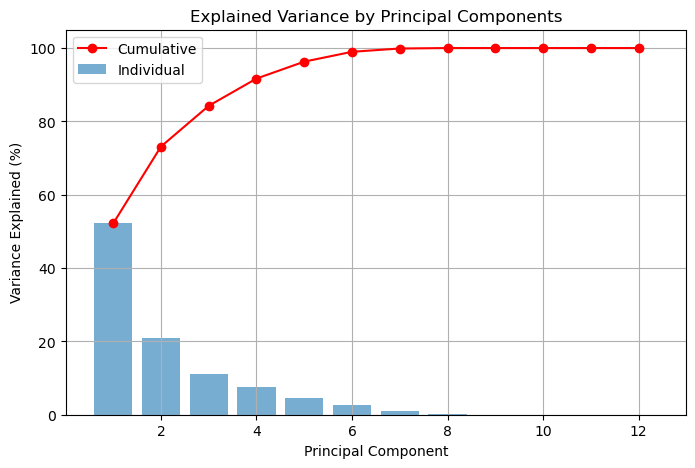

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA on the Z-score matrix
pca = PCA()
pca.fit(z_score_df.T)  # Transpose so samples are rows

# Get explained variance ratio
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to percentage
cumulative_variance = np.cumsum(explained_variance)  # Cumulative sum
print(f"cumulative_variance: {cumulative_variance}")

# Plot explained variance
plt.figure(figsize=(8,5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label="Individual")
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='r', label="Cumulative")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.title("Explained Variance by Principal Components")
plt.legend()
plt.grid()
plt.show()



In [56]:
# Perform PCA with 4 components
pca = PCA(n_components=4)
pca_results = pca.fit_transform(z_score_df.T)  # Transpose so samples are rows

# Create DataFrame with PCA results
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df['Pig'] = z_score_df.columns  # Match sample names
pca_df = pca_df.merge(metadata_df, on='Pig')  # Add treatment labels
display(pca_df)
# Plot PC1 vs PC2
fig = px.scatter(
    pca_df,
    x='PC1',
    y='PC2',
    color='Treatment',  # Color by treatment group
    hover_data=['Pig'],
    title="PCA of RNA-Seq Expression Data (PC1 vs. PC2)",
    labels={'PC1': f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)",
            'PC2': f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)"},
    template="plotly_white"
)

fig.show()


,PC1,PC2,PC3,PC4,Pig,Treatment,Day Euthanized,Max Fecal Score
0,-3.973824e+06,-7.706437e+05,-5.198655e+05,3.695259e+05,PIG1,Sham,21,0
1,-3.973824e+06,-7.706437e+05,-5.198655e+05,3.695259e+05,PIG2,Sham,21,0
2,-3.973824e+06,-7.706437e+05,-5.198655e+05,3.695259e+05,PIG3,Sham,21,0
3,-3.973824e+06,-7.706437e+05,-5.198655e+05,3.695259e+05,PIG4,Sham,21,0
4,-3.642505e+06,3.579460e+05,-4.453735e+04,-1.644598e+05,PIG5,Bhyo,21,2
5,1.577431e+05,3.852351e+06,1.397021e+06,-2.242095e+06,PIG6,Bhyo,14,4
6,5.035853e+06,-3.028552e+06,-2.382101e+06,-1.890297e+05,PIG7,Bhyo,11,4
7,4.289303e+06,1.379091e+06,-6.086191e+05,-1.089123e+06,PIG8,Bhyo,18,4
8,7.891990e+05,2.494548e+06,-1.354955e+06,-1.228772e+06,PIG9,Bhamp,21,1
9,3.957418e+06,-4.081150e+06,9.197498e+05,-8.502229e+05,PIG10,Bhamp,21,1


All the control points will condense onto a single one here

In [58]:
#Plot in 3d
fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Treatment',
    hover_data=['Pig'],
    title="PCA of RNA-Seq Expression Data (PC1 vs. PC2 vs. PC3)",
    labels={'PC1': f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)",
            'PC2': f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)",
            'PC3': f"PC3 ({pca.explained_variance_ratio_[2]*100:.2f}% Variance)"},
    template="plotly_white"
)

fig.show()

fig.write_html("./data/outputs/rnaseq/PCA_3D_plotly.html")
print("Heatmap saved as HTML!")

Heatmap saved as HTML!


### PCA on the high variance natural log data

cumulative_variance: [ 32.64492147  51.4762054   61.44725669  68.7396754   74.98512558
  80.46788612  85.22330643  89.81908686  93.5634051   97.03518699
 100.         100.        ]


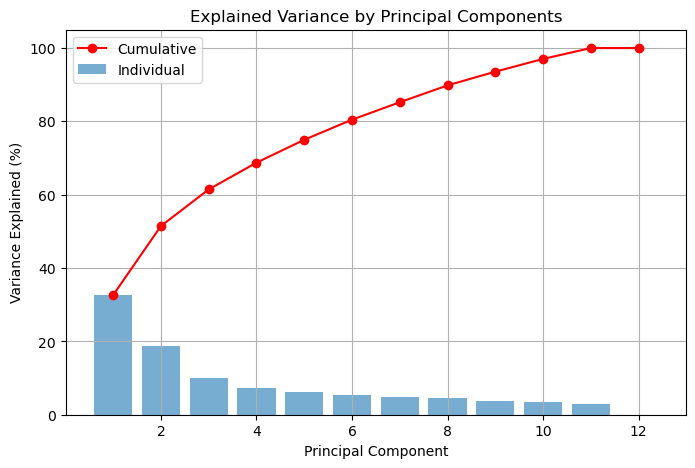

In [53]:
# Perform PCA on the ln matrix
pca = PCA()
pca.fit(high_variance_ln_df.T)  # Transpose so samples are rows

# Get explained variance ratio
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to percentage
cumulative_variance = np.cumsum(explained_variance)  # Cumulative sum
print(f"cumulative_variance: {cumulative_variance}")

# Plot explained variance
plt.figure(figsize=(8,5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label="Individual")
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='r', label="Cumulative")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.title("Explained Variance by Principal Components")
plt.legend()
plt.grid()
plt.show()

In [54]:
# Perform PCA with 4 components
pca = PCA(n_components=8)
pca_results = pca.fit_transform(high_variance_ln_df.T)  # Transpose so samples are rows

# Create DataFrame with PCA results
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])
pca_df['Pig'] = z_score_df.columns  # Match sample names
pca_df = pca_df.merge(metadata_df, on='Pig')  # Add treatment labels
display(pca_df)
# Plot PC1 vs PC2
fig = px.scatter(
    pca_df,
    x='PC1',
    y='PC2',
    color='Treatment',  # Color by treatment group
    hover_data=['Pig'],
    title="PCA of RNA-Seq Expression Data (PC1 vs. PC2)",
    labels={'PC1': f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)",
            'PC2': f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)"},
    template="plotly_white"
)

fig.show()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Pig,Treatment,Day Euthanized,Max Fecal Score
0,38.233995,-11.193425,-7.735340,6.806449,12.967730,-1.436353,11.667407,10.763516,PIG1,Sham,21,0
1,27.904582,-5.657461,9.341814,-0.764579,4.069230,-15.653075,2.570020,-10.442601,PIG2,Sham,21,0
2,26.583446,-11.476778,-13.936593,11.247840,-16.514237,15.621159,-4.075655,-7.800176,PIG3,Sham,21,0
3,11.011024,58.700997,3.882581,6.666059,-1.082954,1.963381,-0.642995,3.107469,PIG4,Sham,21,0
4,23.530984,-4.722360,10.647442,-14.744357,2.233107,9.224545,0.711951,-8.553073,PIG5,Bhyo,21,2
5,4.728097,-6.753638,8.957165,-12.145869,-17.183198,-13.258458,-1.321649,15.027606,PIG6,Bhyo,14,4
6,-33.030943,2.423037,9.898667,-14.830517,-3.706306,8.889608,14.117468,-7.028791,PIG7,Bhyo,11,4
7,-18.245955,-1.653892,-20.496540,-3.084414,-12.244892,-3.284120,-4.269536,4.838116,PIG8,Bhyo,18,4
8,-24.475418,-8.510871,16.088544,21.881592,-2.301006,-9.525438,-6.547557,-9.025311,PIG9,Bhamp,21,1
9,-31.304814,-9.078797,0.726241,13.197941,6.300180,6.761643,12.129925,9.296798,PIG10,Bhamp,21,1
